In [12]:
import PIL.Image as pilimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(threshold=1000000)

YOUR_IMAGE_PATH = '적외선영상.png'
im = pilimg.open(YOUR_IMAGE_PATH) # image의 size = 339X296
print(im)

pix = np.array(im) # img를 array로 변경??? how? 알아서 잘
print(pix.shape) # img shape, 296, 339, 3
# alpha = pix[:, :, 2]
# print(alpha.shape)
# print(pix)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=339x296 at 0x2745947A0B8>
(296, 339, 3)


In [13]:
im = pilimg.fromarray(pix)
im.save('적외선영상2.png')

In [14]:
data = pd.read_csv('온도.csv', sep=',')
arr_cel = np.asarray(data.온도)
arr_cel = arr_cel.reshape(1000, 1) # 왜??????????????????????
print(arr_cel.shape)

data.head()

(1000, 1)


,번호,온도
0,1,19.374425
1,2,33.998988
2,3,18.681899
3,4,30.741560
4,5,21.291808


In [28]:
# 적외선 사진들을 이용해서 가장 큰 dimension 측정

all_file_dim = []

for i in range(0, 1000): # 적외선 영상들은 흑백임 img mode=L 즉, array도 2차원임
    filename2 = '적외선영상_' + str(i+1) + '.png'
    YOUR_IMAGE_PATH2 = 'YANG\\' + filename2
    
    im = pilimg.open(YOUR_IMAGE_PATH2)
#     print(im.size)
    
    pix = np.array(im)
    dim = pix.shape
#     print(dim)
    all_file_dim.append(dim)
    
frame = pd.DataFrame(all_file_dim, columns = ['x', 'y'])
np.max(frame.x), np.max(frame.y)

(197, 195)

In [29]:
# 이미지의 최대 사이즈가 197, 195이므로 200, 200으로 규격화
# 기존 사이즈를 넘는 크기인 경우 0으로 대체됨.

pix_all = []

for i in range(0, 1000): # 적외선 영상들은 흑백임 img mode=L 즉, array도 2차원임
    filename = '적외선영상_' + str(i+1) + '.png'
    YOUR_IMAGE_PATH = 'YANG\\' + filename
    
    im = pilimg.open(YOUR_IMAGE_PATH)
    pix = np.array(im)
    pix = pix/255
    
    width, height = pix.shape
    pix2 = np.zeros((200, 200))
    pix2[:width, :height] = pix
    pix2 = pix2.reshape(200, 200, 1) # 왜??????????????????????
    
    pix_all.append(pix2)
    
arr_pix_all = np.asarray(pix_all)
print(arr_pix_all.shape) # 1000, 200, 200, 1


(1000, 200, 200, 1)


In [30]:
cnt = 1
pix_train = []
pix_test = []
pix_valid = []

for i in arr_pix_all: # 1000개의 (200, 200, 1)을 나눔
    if cnt <= 600:
        pix_train.append(i)
    elif cnt > 600 and cnt <= 900:
        pix_valid.append(i)
    else:
        pix_test.append(i)
        
    cnt+=1
    
arr_pix_train = np.asarray(pix_train)
arr_pix_test = np.asarray(pix_test)
arr_pix_valid = np.asarray(pix_valid)


In [31]:
cnt = 1
cel_train = []
cel_test = []
cel_valid = []

for i in arr_cel: 
    if cnt <= 600:
        cel_train.append(i)
    elif cnt > 600 and cnt <= 900:
        cel_valid.append(i)
    else:
        cel_test.append(i)
        
    cnt+=1
    
arr_cel_train = np.asarray(cel_train)
arr_cel_test = np.asarray(cel_test)
arr_cel_valid = np.asarray(cel_valid)

In [32]:
print(arr_pix_train.shape, arr_pix_test.shape, arr_pix_valid.shape)
print(arr_cel_train.shape, arr_cel_test.shape, arr_cel_valid.shape)

(600, 200, 200, 1) (100, 200, 200, 1) (300, 200, 200, 1)
(600, 1) (100, 1) (300, 1)


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

width = 200
height = 200

x_train, y_train = arr_pix_train, arr_cel_train
x_val, y_val = arr_pix_valid, arr_cel_valid
x_test, y_test = arr_pix_test, arr_cel_test

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, 1)))
# 64 == 컨볼루션 필터의 수, (3, 3) == 컨볼루션 커널의 (행, 열)
# input_shape (행, 열, 채널 수) 흑백이면 채널 1, rgb는 3으로 설정
# 즉, 3, 3 필터 64개를 이용해서 출력 이미지도 64개가 된다.
model.add(MaxPooling2D(pool_size=(2, 2)))
# pool)size : 수직, 수평 축소 비율로 2, 2면 출력 영상 크기는 입력 영상의 반으로 줄음
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# 컨볼루션, 맥스풀링 레이어는 2차원 데이터를 다루지만 전결합층에 전달하기 위해서
# 1차원 자료로 변경 필요. 그때 사용하는게 flatten()
model.add(Dense(512, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

hist = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))

Using TensorFlow backend.


Train on 600 samples, validate on 300 samples
Epoch 1/30
600/600 [==============================] - 48s 81ms/step - loss: 329.3759 - val_loss: 172.9430
Epoch 2/30
600/600 [==============================] - 42s 69ms/step - loss: 85.8550 - val_loss: 61.2020
Epoch 3/30
600/600 [==============================] - 48s 79ms/step - loss: 55.5719 - val_loss: 54.9816
Epoch 4/30
600/600 [==============================] - 57s 95ms/step - loss: 43.8510 - val_loss: 47.8062
Epoch 5/30
600/600 [==============================] - 56s 94ms/step - loss: 39.6136 - val_loss: 48.4342
Epoch 6/30
600/600 [==============================] - 57s 95ms/step - loss: 38.5266 - val_loss: 48.0724
Epoch 7/30
600/600 [==============================] - 57s 95ms/step - loss: 36.8679 - val_loss: 48.6155
Epoch 8/30
600/600 [==============================] - 57s 94ms/step - loss: 36.0316 - val_loss: 47.3694
Epoch 9/30
600/600 [==============================] - 57s 94ms/step - loss: 35.3229 - val_loss: 47.9087
Epoch 10/30
600/

100/100 [==============================] - 1s 12ms/step

 Test Accuracy: 47.8485
30


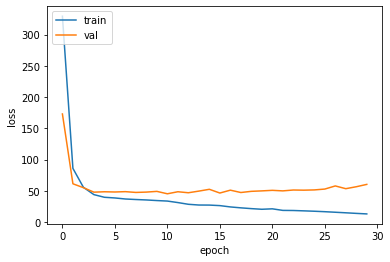

100/100 [==============================] - 1s 13ms/step
47.84852296829224


In [51]:
print('\n Test Accuracy: {0:0.4f}'.format(model.evaluate(x_test, y_test)))

y_vloss = hist.history['val_loss'] # ephocs를 돌면서 나온 vloss의 기록을 의미

print(len(y_vloss)) # 30개, ephoc이 30까지 가기 때문.

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

score = model.evaluate(x_test, y_test, batch_size=32)

print(score)

yhat_test = model.predict(x_test, batch_size=32)

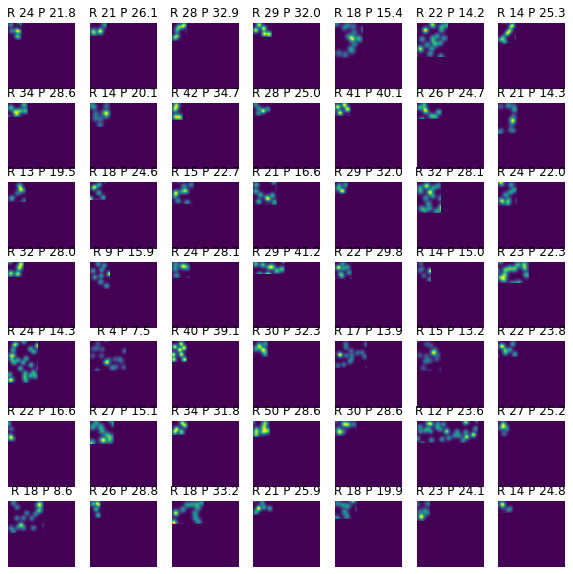

In [58]:
plt_row = 7
plt_col = 7

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[(int)(i/plt_row), i%plt_col] # (0,0)~(0,6)->(1,0)~(1,6)
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height)) # 200, 200변환
    sub_plt.set_title('R %d P %.1f' % (y_test[i][0], yhat_test[i][0]))

plt.show()